In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import multiprocessing

from IPython.display import Markdown
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold, GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge

# Import helperfunctions
from ML_functions import fun_load_settings, fun_load_data, fun_preprocessing, fun_fit_tuning
from ML_functions import fun_convert_time
from ML_functions import fun_scaled_neg_MAPE, fun_tuning_results, fun_scores
from ML_functions import plot_feature_weights

# Set the default optimization problem for the case of manual executing the script (choose either "TSP" or "CVRP")
default_optimization_problem = "TSP"

# Call the function to define optimization_problem based on how the notebook is executed
# If the notebook is run by the script "main.ipynb", load optimization_problem from "settings.json". Otherwise use the default optimization problem from above
optimization_problem = fun_load_settings(default_optimization_problem)

# Load data and start the time count for the script within the function fun_load_data
data, start_script = fun_load_data(optimization_problem)

# Do the train test split during the preprocessing
X_train, X_test, y_train, y_test, train_data = fun_preprocessing(data, train_size=0.8)

# View the data frame and the column names (the features and the target variable)
display(train_data, train_data.columns)
print(f"Number of features: {len(train_data.columns.drop('Shapley Value'))}")
print(f"Number of columns: {len(train_data.columns)}")
print(f"Number of rows (customers): {len(train_data)}")

The notebook was executed by another notebook. :)
Optimization problem: 'TSP'


,,Number Customers,X Ratio,Y Ratio,X Depot,Y Depot,Depot Distance Ratio,Closest Customer Distance (CCD) Ratio,2nd CCD Ratio,3rd CCD Ratio,4th CCD Ratio,...,Y Max,X Min,Y Min,Correlation,Skewness X,Skewness Y,Savings Ratio,Marginal Cost Ratio,Total Cost,Shapley Value
Index,Instance ID,,,,,,,,,,,,,,,,,,,,,
0,1,6,0.259951,1.437562,2.380844,66.016752,0.320244,1.262503,1.068225,1.045933,1.274274,...,58.267699,11.757432,0.942942,-0.026968,0.267574,-0.668709,0.022796,0.021584,227.291186,6.805996
1,1,6,1.840139,1.174308,2.380844,66.016752,1.517015,1.419479,1.246244,1.253743,1.131794,...,58.267699,11.757432,0.942942,-0.026968,0.267574,-0.668709,2.161204,2.365312,227.291186,73.361446
2,1,6,0.730341,0.844653,2.380844,66.016752,0.851033,0.386302,0.876273,0.782974,0.736554,...,58.267699,11.757432,0.942942,-0.026968,0.267574,-0.668709,0.186036,0.176144,227.291186,21.568006
3,1,6,0.931506,0.869513,2.380844,66.016752,0.954254,0.386302,0.880063,0.735429,0.758701,...,58.267699,11.757432,0.942942,-0.026968,0.267574,-0.668709,0.514850,0.487476,227.291186,25.980268
4,1,6,1.196190,1.647306,2.380844,66.016752,0.939229,1.267963,0.985226,0.860173,0.895617,...,58.267699,11.757432,0.942942,-0.026968,0.267574,-0.668709,0.101425,0.096032,227.291186,30.191952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,9000,14,0.762350,0.248901,83.308855,83.076767,1.472871,0.397873,0.780109,1.051643,1.406486,...,98.194459,15.703090,4.059342,-0.167460,1.100434,-0.368078,0.368519,0.305413,370.421950,32.946966
89996,9000,14,2.024272,0.074775,83.308855,83.076767,1.390589,2.420974,2.384855,2.095157,1.840427,...,98.194459,15.703090,4.059342,-0.167460,1.100434,-0.368078,4.429439,3.670935,370.421950,70.014213
89997,9000,14,0.338063,1.149555,83.308855,83.076767,1.232837,1.326033,1.011522,0.893990,0.902444,...,98.194459,15.703090,4.059342,-0.167460,1.100434,-0.368078,2.593953,2.536474,370.421950,37.349798


Index(['Number Customers', 'X Ratio', 'Y Ratio', 'X Depot', 'Y Depot',
       'Depot Distance Ratio', 'Closest Customer Distance (CCD) Ratio',
       '2nd CCD Ratio', '3rd CCD Ratio', '4th CCD Ratio', '5th CCD Ratio',
       '6th CCD Ratio', '7th CCD Ratio', '8th CCD Ratio',
       'Mean Distance To Other Customers Ratio',
       'Gravity Center Distance Ratio', 'Number Clusters', 'Cluster Size',
       'X Centroid', 'Y Centroid', 'Centroid Distance To Depot Ratio',
       'Cluster Area Ratio', 'Cluster Density Ratio', 'X Std', 'Y Std',
       'X Max', 'Y Max', 'X Min', 'Y Min', 'Correlation', 'Skewness X',
       'Skewness Y', 'Savings Ratio', 'Marginal Cost Ratio', 'Total Cost',
       'Shapley Value'],
      dtype='object')

Number of features: 35
Number of columns: 36
Number of rows (customers): 90000


# **A. Instance-based models**
### **1. K-nearest Neighbor - KNN**
- RobustScaler did not perform

In [2]:
# Grid search cross validation with data scaling
pipe = Pipeline(steps=[("scaler", None), 
                       ("knn", KNeighborsRegressor())])

param_grid = {"scaler": [StandardScaler(), MinMaxScaler()], 
              "knn__n_neighbors": list(np.arange(start=7, stop=13))}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                           # Cross-validation with GroupKFold to keep instances together in one fold
                           cv=GroupKFold(n_splits=3).split(X_train, y_train, 
                                                           groups=X_train.index.get_level_values(level="Instance ID")), 
                           scoring=fun_scaled_neg_MAPE, refit=False, verbose=True, n_jobs=-1)
tuning_details = fun_fit_tuning(search_method=grid_search, X_train=X_train, y_train=y_train, file_name=f"{optimization_problem}_KNN")

# View results of grid search cross validation
model_results_dict = fun_scores(model=grid_search, X_train=X_train, y_train=y_train)
model_results_dict.update(tuning_details)

# Create a dictionary to store the results
results_dict = {"KNN": model_results_dict}

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=grid_search, search_space=param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 12,
 'Total tuning time': '39s',
 'Total tuning fit time': '1s',
 'Total tuning prediction time': '2m, 12s'}

CV MAPE (scaled) train data: 22.66 %


**Best model / parameter combination:**

{'knn__n_neighbors': 8, 'scaler': StandardScaler()}

**Cross validation scores of different parameter combinations:**

,scaler,n_neighbors,mean_test_score,converted_mean_fit_time
0,StandardScaler(),8,-0.226569,0s
1,StandardScaler(),9,-0.226663,0s
2,StandardScaler(),7,-0.226671,0s
3,StandardScaler(),10,-0.226907,0s
4,StandardScaler(),11,-0.227685,0s
5,StandardScaler(),12,-0.228240,0s
6,MinMaxScaler(),8,-0.236505,0s
7,MinMaxScaler(),9,-0.236640,0s
8,MinMaxScaler(),7,-0.236792,0s
9,MinMaxScaler(),10,-0.237643,0s


# **B. Linear Models**
### **1. Linear Regression**
- the model has no parameters. Thus, only cross-validation is conducted and no grid search cross-validation

CV MAPE (scaled) train data: 20.64 %
CV RMSE (scaled) train data: 4.29
CV computation time: 0s


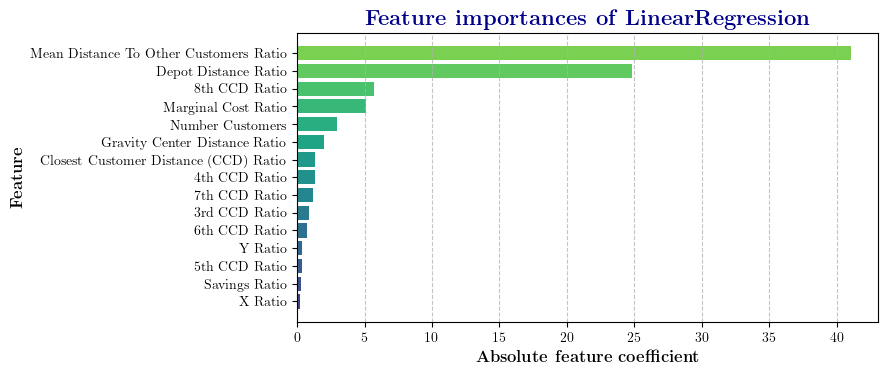

In [3]:
if (optimization_problem == "TSP"):
    
    # Create model
    lr = LinearRegression()

    # Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
    model_results_dict = fun_scores(lr, X_train, y_train, apply_scaling=True)

    # Save results to dictionary
    results_dict["Linear Regression"] = model_results_dict

    # Fit model on train set (default parameters) and show top 15 absolute feature weights
    plot_feature_weights(model=lr.fit(X_train, y_train), n_features=15)

else: print("This cell is only executed for the TSP!")

### **2. Rigde Regression (L2-Regularization)**
- higher alpha means higher regularization and lower model complexity (less overfitting); alpha=0 means linear regression

In [4]:
if (optimization_problem == "TSP"):

    # Grid search cross validation
    param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

    grid_search = GridSearchCV(estimator=Ridge(solver="svd"), param_grid=param_grid, 
                            cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train.index.get_level_values(level="Instance ID")),
                            scoring=fun_scaled_neg_MAPE, refit=False, verbose=True, n_jobs=-1)
    tuning_details = fun_fit_tuning(grid_search, X_train, y_train, file_name=f"{optimization_problem}_Ridge")

    # View results of grid search cross validation
    model_results_dict = fun_scores(grid_search, X_train, y_train)
    model_results_dict.update(tuning_details)

    # Save results to dictionary
    results_dict["Ridge Regression"] = model_results_dict

    # View grid search CV scores of all parameter combinations
    results_df = fun_tuning_results(grid_search, param_grid)

else: print("This cell is only executed for the TSP!")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 5,
 'Total tuning time': '1s',
 'Total tuning fit time': '4s',
 'Total tuning prediction time': '0s'}

CV MAPE (scaled) train data: 20.64 %


**Best model / parameter combination:**

{'alpha': 1}

**Cross validation scores of different parameter combinations:**

,alpha,mean_test_score,converted_mean_fit_time
0,1.000,-0.206423,0s
1,0.100,-0.206428,0s
2,0.010,-0.206429,0s
3,0.001,-0.206430,0s
4,10.000,-0.206676,0s


### **3. Polynomial Regression**
#### **3.1 Polynomial Regression step by step**
**Apply binning (one hot encoding) for most important continuous features**

In [5]:
# Load most important features from script "b1_feature_selection.ipynb" and get a list with all features
top20_features = list(pd.read_csv(f"02_best_features/{optimization_problem}_top20_features"))
all_features = list(X_train.columns)

# Example with 5 bins per feature
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")
binned_features = discretizer.fit_transform(X_train[top20_features])
binned_df = pd.DataFrame(binned_features, columns=[f"{col} binned" for col in top20_features])
display(X_train[top20_features].head(5))
display(binned_df.head(5))

,,Depot Distance Ratio,Marginal Cost Ratio,Mean Distance To Other Customers Ratio,7th CCD Ratio,8th CCD Ratio,Savings Ratio,Cluster Size,Number Customers,6th CCD Ratio,Gravity Center Distance Ratio,Centroid Distance To Depot Ratio,Cluster Area Ratio,Y Std,Closest Customer Distance (CCD) Ratio,4th CCD Ratio,5th CCD Ratio,Total Cost,X Std,Y Depot,X Depot
Index,Instance ID,,,,,,,,,,,,,,,,,,,,
0,1,0.320244,0.021584,1.175178,1.0,1.0,0.022796,5,6,1.0,1.442905,0.885295,1.199907,18.432836,1.262503,1.274274,1.211060,227.291186,21.621684,66.016752,2.380844
1,1,1.517015,2.365312,1.230834,1.0,1.0,2.161204,1,6,1.0,1.506247,1.573524,0.000465,18.432836,1.419479,1.131794,1.211060,227.291186,21.621684,66.016752,2.380844
2,1,0.851033,0.176144,0.766016,1.0,1.0,0.186036,5,6,1.0,0.523415,0.885295,1.199907,18.432836,0.386302,0.736554,0.865881,227.291186,21.621684,66.016752,2.380844
3,1,0.954254,0.487476,0.718498,1.0,1.0,0.514850,5,6,1.0,0.217502,0.885295,1.199907,18.432836,0.386302,0.758701,0.713908,227.291186,21.621684,66.016752,2.380844
4,1,0.939229,0.096032,0.967599,1.0,1.0,0.101425,5,6,1.0,0.960795,0.885295,1.199907,18.432836,1.267963,0.895617,0.970327,227.291186,21.621684,66.016752,2.380844


,Depot Distance Ratio binned,Marginal Cost Ratio binned,Mean Distance To Other Customers Ratio binned,7th CCD Ratio binned,8th CCD Ratio binned,Savings Ratio binned,Cluster Size binned,Number Customers binned,6th CCD Ratio binned,Gravity Center Distance Ratio binned,Centroid Distance To Depot Ratio binned,Cluster Area Ratio binned,Y Std binned,Closest Customer Distance (CCD) Ratio binned,4th CCD Ratio binned,5th CCD Ratio binned,Total Cost binned,X Std binned,Y Depot binned,X Depot binned
0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,3.0,0.0
1,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,3.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,0.0


In [6]:
# Binning of the 20 most important features to create a data frame with the bin affiliation for each feature (value between 0 and 4)
n_bins = 5
discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")
binned_features = discretizer.fit_transform(X_train[top20_features])
binned_df = pd.DataFrame(binned_features, columns=[f"{col} binned" for col in top20_features])

# One-Hot Encoding the binned features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(binned_df)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(binned_df.columns), index=X_train.index)

# Combine with original data
X_train_onehot = pd.concat([X_train, one_hot_encoded_df], axis=1)
display(X_train_onehot.head()) # 6 columns are missing in the binning columns as there probably was no value in these bins of the feature

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_onehot, y_train=y_train, apply_scaling=True)

# Save results to dictionary
results_dict["Linear Regression One hot"] = model_results_dict

,,Number Customers,X Ratio,Y Ratio,X Depot,Y Depot,Depot Distance Ratio,Closest Customer Distance (CCD) Ratio,2nd CCD Ratio,3rd CCD Ratio,4th CCD Ratio,...,Y Depot binned_0.0,Y Depot binned_1.0,Y Depot binned_2.0,Y Depot binned_3.0,Y Depot binned_4.0,X Depot binned_0.0,X Depot binned_1.0,X Depot binned_2.0,X Depot binned_3.0,X Depot binned_4.0
Index,Instance ID,,,,,,,,,,,,,,,,,,,,,
0,1,6,0.259951,1.437562,2.380844,66.016752,0.320244,1.262503,1.068225,1.045933,1.274274,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,6,1.840139,1.174308,2.380844,66.016752,1.517015,1.419479,1.246244,1.253743,1.131794,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,6,0.730341,0.844653,2.380844,66.016752,0.851033,0.386302,0.876273,0.782974,0.736554,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,6,0.931506,0.869513,2.380844,66.016752,0.954254,0.386302,0.880063,0.735429,0.758701,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,6,1.196190,1.647306,2.380844,66.016752,0.939229,1.267963,0.985226,0.860173,0.895617,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


CV MAPE (scaled) train data: 20.46 %
CV RMSE (scaled) train data: 4.26
CV computation time: 1s


##### **Add Interactions and Polynomials** <br>
Let's break down why the binomial coefficient for degree 3 (cubic terms). The formula is:
The formula to compute the number of polynomial features is a binomial coefficient. The binomial coefficient for $n$ original features and degree $d$ is calculated as:
$$
\binom{n + d - 1}{d}
$$

**Degree 0 (constant term):**
$$
\binom{20 + 0 - 1}{0} = \binom{19}{0} = \frac{19!}{0!(19 - 1)!} = \frac{19 \times 18!}{0! \times 18!} = \frac{19}{0} = 1
$$

**Degree 1 (linear terms, the original features):**
$$
\binom{20 + 1 - 1}{1} = \binom{20}{1} = \frac{20!}{1!(20 - 1)!} = \frac{20 \times 19!}{1! \times 19!} = \frac{20}{1} = 20
$$

**Degree 2 (quadratic terms, pairwise combinations):**
$$
\binom{20 + 2 - 1}{2} = \binom{21}{2} = \frac{21!}{2!(21 - 2)!} = \frac{21 \times 20 \times 19!}{2! \times 19!} = \frac{21 \times 20}{2} = 210
$$

**Degree 3 (cubic terms, three-way combinations):**
$$
\binom{20 + 3 - 1}{3} = \binom{22}{3} = \frac{22!}{3!(22 - 3)!} = \frac{22 \times 21 \times 20 \times 19!}{3! \times 19!} = \frac{22 \times 21 \times 20}{3 \times 2 \times 1} = 1540
$$

**Total Number of Features:**

Now, summing these values gives us the total number of polynomial features:
$$
1 + 20 + 210 + 1540 = 1771
$$

In [7]:
# Generate polynomial features with all polynomial combinations of the features up to the specified degree
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=True)

# Fit and transform the data and generate a data frame
X_poly_top20 = poly.fit_transform(X_train[top20_features])
poly_df_top20 = pd.DataFrame(X_poly_top20, index=X_train_onehot.index)
X_poly_all = poly.fit_transform(X_train[all_features])
poly_df_all = pd.DataFrame(X_poly_all, index=X_train_onehot.index)

# Number of polynomial features
n_polynomial_features_top20 = X_poly_top20.shape[1]
n_polynomial_features_all = X_poly_all.shape[1]

# Print results
display(Markdown("**Using the top 20 features:**"))
print(f"Number of remaining original features:", original_features := len(X_train.columns) - len(top20_features))
print(f"Number of binning features:", binnig_features := n_bins * len(top20_features))
print(f"Number of polynomial features: {n_polynomial_features_top20}")
print(f"Total number of features: {original_features} + {binnig_features} + {n_polynomial_features_top20} = {original_features + binnig_features + n_polynomial_features_top20}\n")

display(Markdown("**Using all features:**"))
print(f"Number of remaining original features:", original_features := len(X_train.columns) - len(all_features))
print(f"Number of binning features:", binnig_features := n_bins * len(top20_features))
print(f"Number of polynomial features: {n_polynomial_features_all}")
print(f"Total number of features: {original_features} + {binnig_features} + {n_polynomial_features_all} = {original_features + binnig_features + n_polynomial_features_all}")

**Using the top 20 features:**

Number of remaining original features: 15
Number of binning features: 100
Number of polynomial features: 1771
Total number of features: 15 + 100 + 1771 = 1886



**Using all features:**

Number of remaining original features: 0
Number of binning features: 100
Number of polynomial features: 8436
Total number of features: 0 + 100 + 8436 = 8536


In [8]:
# Add top20 polynomial features to the X_train_onehot data frame
X_train_poly_top20 = pd.concat([X_train_onehot[[i for i in X_train_onehot.columns if i not in top20_features]], poly_df_top20], axis=1)

# Identify the column "Total Cost" and rename it for the scaling part later
for column in X_train_poly_top20.columns:
    if (X_train_poly_top20[column] == X_train["Total Cost"]).all():
        X_train_poly_top20.rename(columns={column: "Total Cost"}, inplace=True)

# Turn all columns into strings (string and int columns are not valid)
X_train_poly_top20.columns = X_train_poly_top20.columns.astype(str)
display(X_train_poly_top20.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_poly_top20, y_train=y_train, apply_scaling=True)

# Save results to dictionary
results_dict["Polynomial Regression Top20"] = model_results_dict

,,X Ratio,Y Ratio,2nd CCD Ratio,3rd CCD Ratio,Number Clusters,X Centroid,Y Centroid,Cluster Density Ratio,X Max,Y Max,...,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770
Index,Instance ID,,,,,,,,,,,,,,,,,,,,,
0,1,0.259951,1.437562,1.068225,1.045933,1,37.629660,34.138395,0.011512,83.228495,58.267699,...,10108.076932,30862.647507,1113.037739,94231.871955,3398.400271,122.560702,287714.969691,10376.219964,374.210424,13.495612
1,1,1.840139,1.174308,1.246244,1.253743,1,83.228495,41.537025,5.942439,83.228495,58.267699,...,10108.076932,30862.647507,1113.037739,94231.871955,3398.400271,122.560702,287714.969691,10376.219964,374.210424,13.495612
2,1,0.730341,0.844653,0.876273,0.782974,1,37.629660,34.138395,0.011512,83.228495,58.267699,...,10108.076932,30862.647507,1113.037739,94231.871955,3398.400271,122.560702,287714.969691,10376.219964,374.210424,13.495612
3,1,0.931506,0.869513,0.880063,0.735429,1,37.629660,34.138395,0.011512,83.228495,58.267699,...,10108.076932,30862.647507,1113.037739,94231.871955,3398.400271,122.560702,287714.969691,10376.219964,374.210424,13.495612
4,1,1.196190,1.647306,0.985226,0.860173,1,37.629660,34.138395,0.011512,83.228495,58.267699,...,10108.076932,30862.647507,1113.037739,94231.871955,3398.400271,122.560702,287714.969691,10376.219964,374.210424,13.495612


CV MAPE (scaled) train data: 6.38 %
CV RMSE (scaled) train data: 1.58
CV computation time: 26s


In [9]:
# Add all polynomial features to the X_train_onehot data frame
X_train_poly_all = pd.concat([X_train_onehot[[i for i in X_train_onehot.columns if i not in all_features]], poly_df_all], axis=1)
display(X_train_poly_all.head())

,,Depot Distance Ratio binned_0.0,Depot Distance Ratio binned_1.0,Depot Distance Ratio binned_2.0,Depot Distance Ratio binned_3.0,Depot Distance Ratio binned_4.0,Marginal Cost Ratio binned_0.0,Marginal Cost Ratio binned_1.0,Marginal Cost Ratio binned_2.0,Marginal Cost Ratio binned_3.0,Marginal Cost Ratio binned_4.0,...,8426,8427,8428,8429,8430,8431,8432,8433,8434,8435
Index,Instance ID,,,,,,,,,,,,,,,,,,,,,
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000012,0.000011,0.118112,0.000011,0.111832,1177.660998,0.000010,0.105886,1115.044788,1.174215e+07
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,10.094552,11.047904,1061.631938,12.091291,1161.894741,111650.553656,13.233219,1271.626578,122195.071956,1.174215e+07
2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.006439,0.006096,7.866410,0.005772,7.448153,9610.858452,0.005465,7.052135,9099.849322,1.174215e+07
3,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.136472,0.129216,60.248245,0.122345,57.044847,26597.823189,0.115840,54.011774,25183.617519,1.174215e+07
4,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.001043,0.000988,2.338139,0.000935,2.213820,5239.731879,0.000886,2.096112,4961.135451,1.174215e+07


#### **3.2 Polynomial Regression with Column Transformer as Preprocessor to create one-hot features, interactions and polynomial features. Select best parameters with Grid Search CV**
- To avoid a system overload during the grid search cv: reduce the number of cores with n_jobs
- The additional features in the CVRP lead to a significantly increasing computation time due to the polynomial terms and interactions
- Decrease the number of parameter combinatins with parameter *bins*

In [10]:
# Get the number of CPU cores on the machine
print(f"Total number of logical CPU cores on this machine: {multiprocessing.cpu_count()} cores")

# Define the preprocessing steps for continuous features
onehot_transformer = Pipeline(steps=[("binning", KBinsDiscretizer(encode="ordinal", strategy="uniform")),
                                     ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

# Combine preprocessing steps using ColumnTransformer
preprocessor_top20 = ColumnTransformer(transformers=[("onehot", onehot_transformer, top20_features), 
                                                     ("poly", PolynomialFeatures(interaction_only=False, include_bias=True), top20_features)], 
                                                     remainder="passthrough")

# Combine preprocessing steps using ColumnTransformer
preprocessor_all = ColumnTransformer(transformers=[("onehot", onehot_transformer, top20_features), 
                                                    ("poly", PolynomialFeatures(interaction_only=False, include_bias=True), all_features)], 
                                                    remainder="passthrough")

# Define the model pipeline
pipe = Pipeline(steps=[("preprocessor", None),
                       ("lr", LinearRegression())])

# Define parameter grid for GridSearchCV
if (optimization_problem == "TSP"): bins = [5, 10, 15]
elif (optimization_problem == "CVRP"): bins = [5] # Reduce computation time since the CVRP has more features in poly_features (5 performs best for the TSP)

param_grid = [{"preprocessor": [preprocessor_top20],
              "preprocessor__onehot__binning__n_bins": bins, 
              "preprocessor__poly__degree": [2, 3]},
              {"preprocessor": [preprocessor_all],
              "preprocessor__onehot__binning__n_bins": bins, 
              "preprocessor__poly__degree": [2, 3]}]

# Set up GridSearchCV
# Reduce number of cores (n_jobs) to avoid system overload for poly_features and degree=3
if (optimization_problem == "TSP"): print("Used cores:", cv_n_jobs := 2) # Make assignment and print at the same time
elif (optimization_problem == "CVRP"): print("Used cores:", cv_n_jobs := 1)
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                           cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train.index.get_level_values(level="Instance ID")), 
                           scoring=fun_scaled_neg_MAPE, refit=False, verbose=True, n_jobs=cv_n_jobs)
tuning_details = fun_fit_tuning(grid_search, X_train, y_train, file_name=f"{optimization_problem}_PR")

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(grid_search, X_train, y_train)
model_results_dict.update(tuning_details)

# Save results to dictionary
results_dict["Polynomial Regression Grid Search"] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(grid_search, param_grid)

Total number of logical CPU cores on this machine: 12 cores
Used cores: 2
Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 12,
 'Total tuning time': '38m, 29s',
 'Total tuning fit time': '23m, 55s',
 'Total tuning prediction time': '15s'}

CV MAPE (scaled) train data: 4.569999999999999 %


**Best model / parameter combination:**

{'feature_set': 'all_features (35)',
 'preprocessor__onehot__binning__n_bins': 5,
 'preprocessor__poly__degree': 3}

**Cross validation scores of different parameter combinations:**

,preprocessor,n_bins,degree,mean_test_score,converted_mean_fit_time
0,all_features (35),5,3,-0.045706,"7m, 44s"
1,all_features (35),10,3,-0.045850,"7m, 56s"
2,all_features (35),15,3,-0.046443,"7m, 7s"
3,top20_features,10,3,-0.063683,14s
4,top20_features,5,3,-0.063799,12s
5,top20_features,15,3,-0.064040,15s
6,all_features (35),15,2,-0.074778,9s
7,all_features (35),10,2,-0.074786,2s
8,all_features (35),5,2,-0.076064,4s
9,top20_features,15,2,-0.095782,3s


**Plot Shapley Values and model predictions**

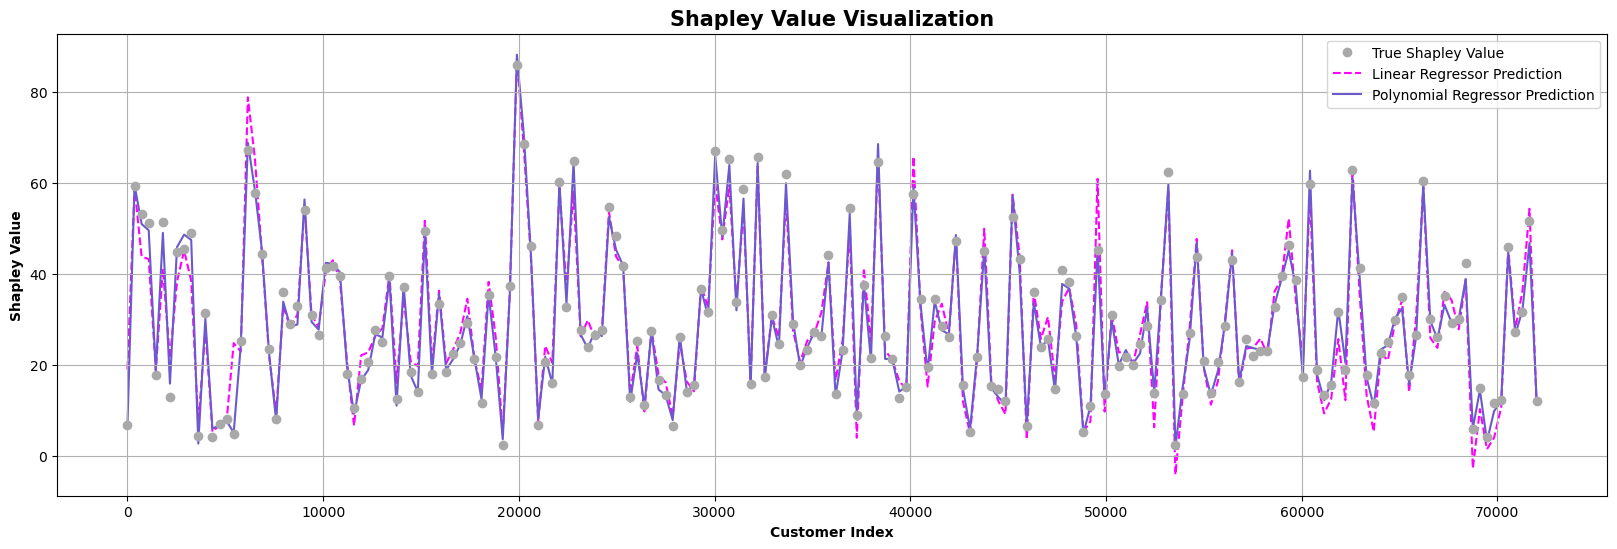

In [11]:
# Fit linear regressor make a prediction
lr = LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_train)

# Fit linear regression on polynomial dataset with top20 features to make predictions
lr = LinearRegression()
lr.fit(X_train_poly_top20, y_train)
poly_reg_pred = lr.predict(X_train_poly_top20)

# Select 200 customer indices
line = np.linspace(0, len(X_train)-1, 200).astype("int")

# Create a plot with 200 True Shapley Values and the predictions from above
plt.figure(figsize=(20, 6))
plt.plot(line, [list(y_train)[i] for i in line], "o", c="darkgrey", label="True Shapley Value", zorder=2)
plt.plot(line, [list(lr_pred)[i] for i in line], "--", c="magenta", label="Linear Regressor Prediction", zorder=0)
plt.plot(line, [list(poly_reg_pred)[i] for i in line], "-", c="slateblue", label="Polynomial Regressor Prediction", zorder=1)
plt.xlabel("Customer Index", size=10, fontweight="bold")
plt.ylabel("Shapley Value", size=10, fontweight="bold")
plt.title("Shapley Value Visualization", size=15, fontweight="bold")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# **C. Compare Results**

In [12]:
display(pd.DataFrame(results_dict).sort_values(by="MAPE", axis=1))
print("Total script computation time:", fun_convert_time(start=start_script, end=time.time()))

,Polynomial Regression Grid Search,Polynomial Regression Top20,Linear Regression One hot,Linear Regression,Ridge Regression,KNN
MAPE,4.57,6.38,20.46,20.64,20.64,22.66
RMSE,None,1.58,4.26,4.29,None,None
CV computation time,None,26s,1s,0s,None,None
Search type,GridSearchCV,NaN,NaN,NaN,GridSearchCV,GridSearchCV
Parameter combinations,12,NaN,NaN,NaN,5,12
Total tuning time,"38m, 29s",NaN,NaN,NaN,1s,39s
Total tuning fit time,"23m, 55s",NaN,NaN,NaN,4s,1s
Total tuning prediction time,15s,NaN,NaN,NaN,0s,"2m, 12s"


Total script computation time: 40m, 44s
